# Conductance-based LIF network

Non-plastic spiking network with conductance-based synapses and balanced state demo (with asynchronous irregular spiking).

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.ndimage import uniform_filter1d as mv_avg
from scipy import stats

from aux import Generic
from disp import set_font_size, set_color
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

## Basic tests

Single-cell response to step current:

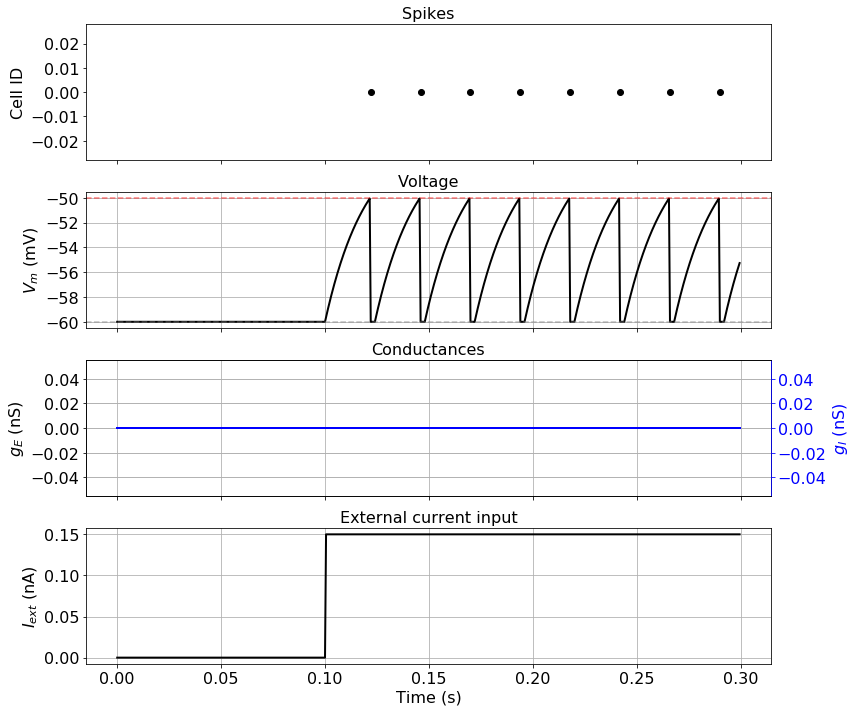

In [2]:
# build 1-cell ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u=None,
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
i_ext[t > 0.1] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell EPSPs:

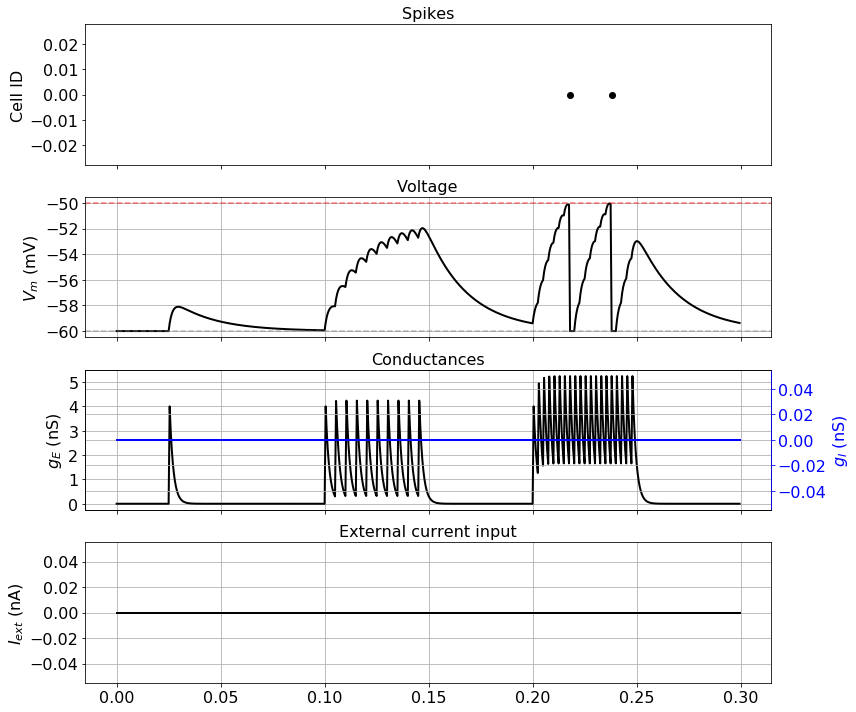

In [3]:
# build 1-cell ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u={'E': 4e-9*np.ones((1, 1))},
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell IPSPs:

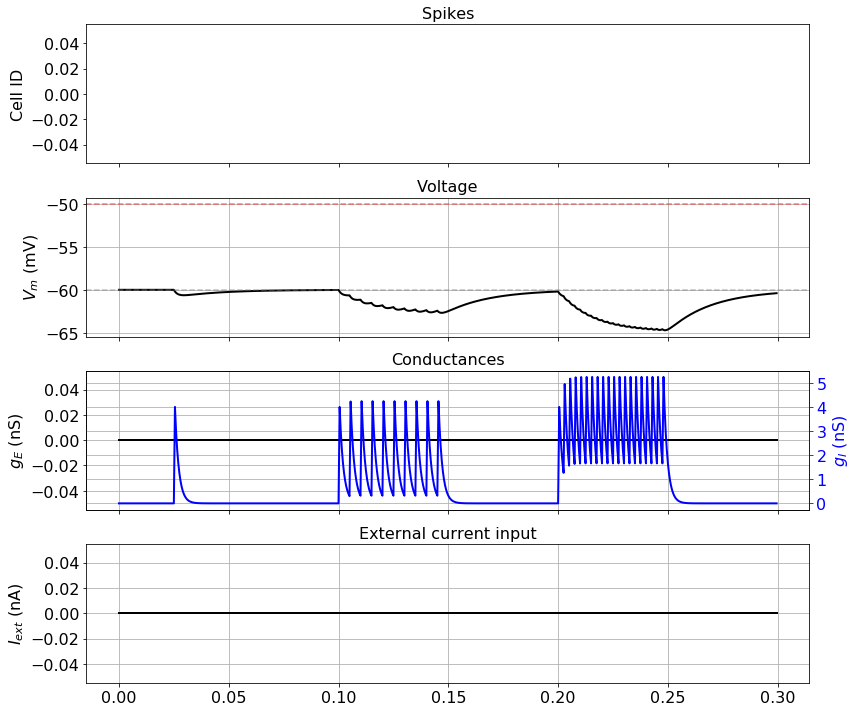

In [4]:
# build 1-cell ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u={'I': 4e-9*np.ones((1, 1))},
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives EPSPs from cell A.

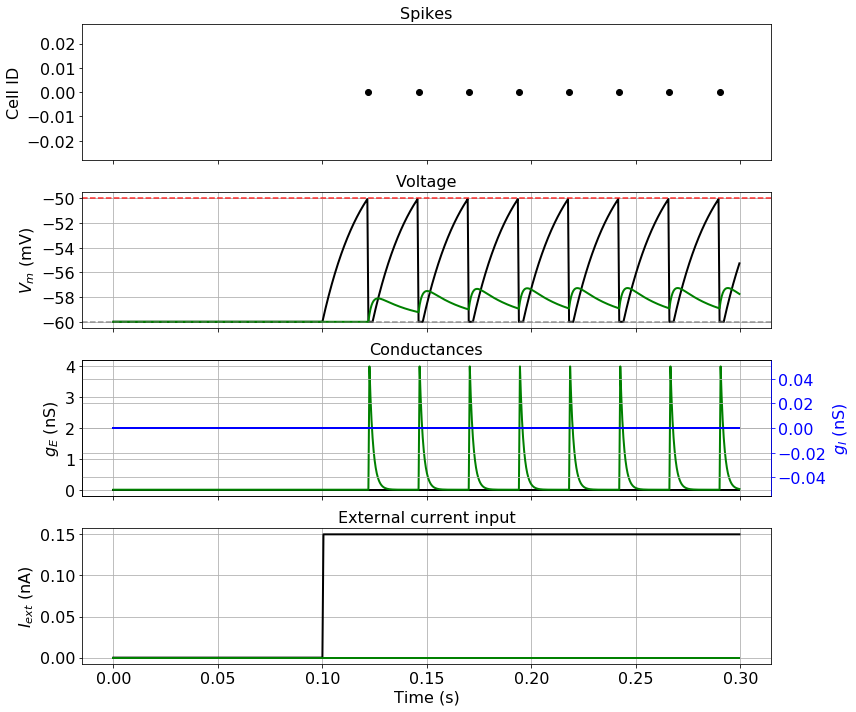

In [5]:
# build 2-cell ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': 4e-9*np.array([[0, 0], [1, 0]]), 'I': np.zeros((2, 2))},
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, i], lw=2, c=c[i])
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, i], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

for i in range(rslt.ntwk.n):
    axs[3].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives IPSPs from cell A.

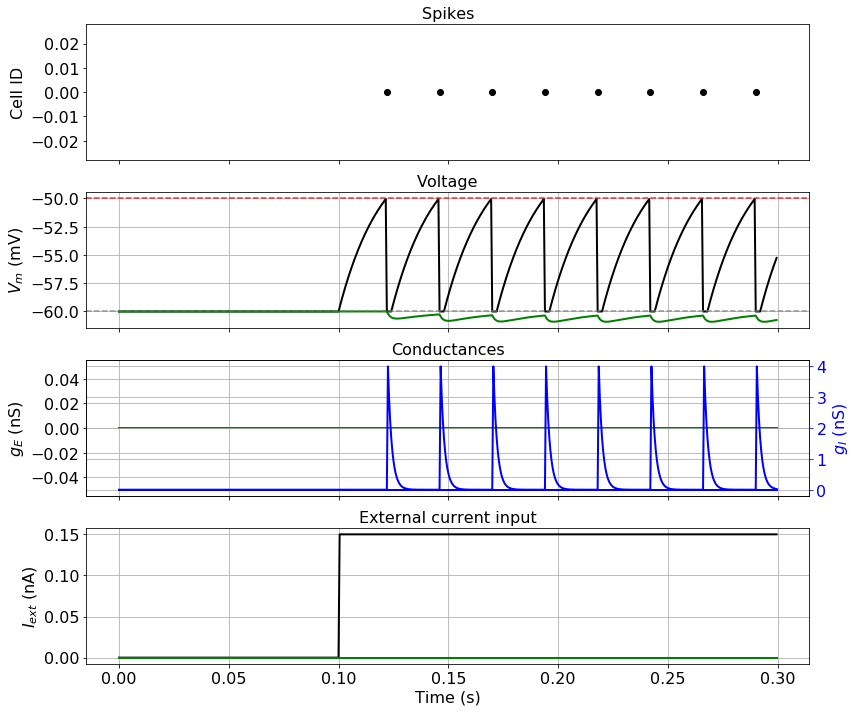

In [6]:
# build 2-cell ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((2, 2)), 'I': 4e-9*np.array([[0, 0], [1, 0]])},
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, i], lw=2, c=c[i])
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, i], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

for i in range(rslt.ntwk.n):
    axs[3].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

## Random network demos

Random EI network response to constant homogeneous input current with I weights turned off.

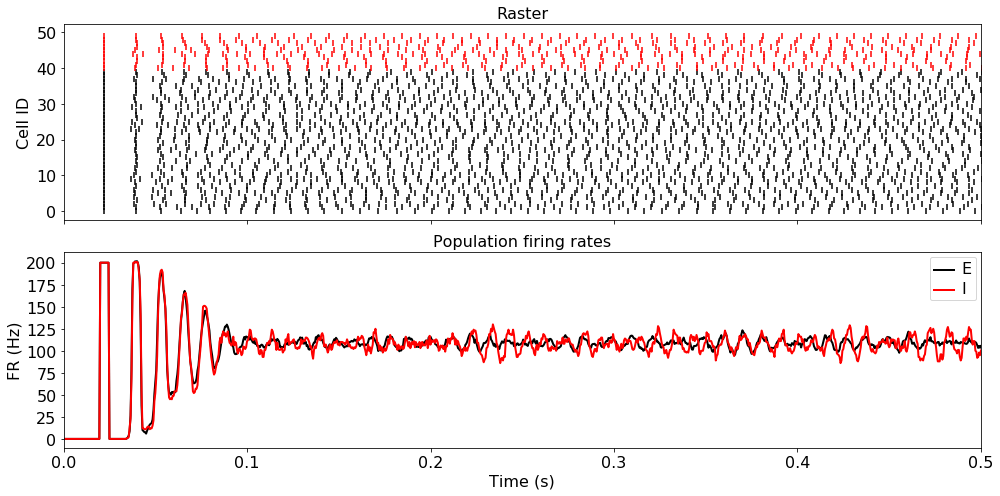

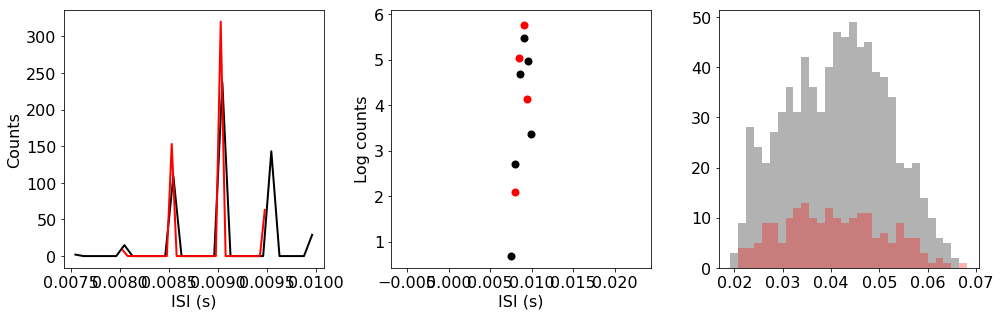

In [7]:
np.random.seed(0)

# set up weight matrix
n_e = 800
n_i = 200
n = n_e + n_i

q = 0.02  # cxn prob
w_ee = 1e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 0  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if False:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = .15e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 40  # first 40 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 10)  # first 10 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 40, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, n_e:].T]
## calc ISI coef of variation
cv_e = np.array([stats.variation(isi) for isi in isis_e])
cv_i = np.array([stats.variation(isi) for isi in isis_i])
cv_e = cv_e[~np.isnan(cv_e)]
cv_i = cv_i[~np.isnan(cv_i)]

## make plots
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5), tight_layout=True)

## example ISIs
for ctr in range(1):
    ### excitatory
    cts_e, bins_e = np.histogram(isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    axs[0].plot(bincs_e, cts_e, c='k', lw=2)
    axs[1].scatter(bincs_e, np.log(cts_e), c='k', lw=2)
    
    ### inhibitory
    cts_i, bins_i = np.histogram(isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    axs[0].plot(bincs_i, cts_i, c='r', lw=2)
    axs[1].scatter(bincs_i, np.log(cts_i), c='r', lw=2)
    
axs[0].set_xlabel('ISI (s)')
axs[0].set_ylabel('Counts')

axs[1].set_xlabel('ISI (s)')
axs[1].set_ylabel('Log counts')

## CV distribution
bins = np.histogram(cc([cv_e, cv_i]), bins=30)[1]
### excitatory
axs[2].hist(cv_e, bins, color='k', alpha=0.3)
axs[2].hist(cv_i, bins, color='r', alpha=0.3)

for ax in axs:
    set_font_size(ax, 16)

Demo of asynchronous irregular dynamics in balanced state.

Equal numbers of E & I neurons.

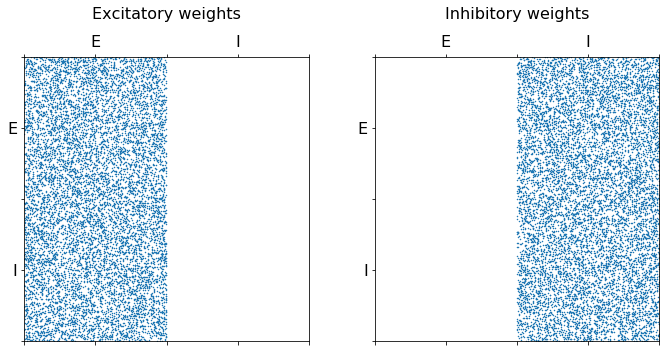

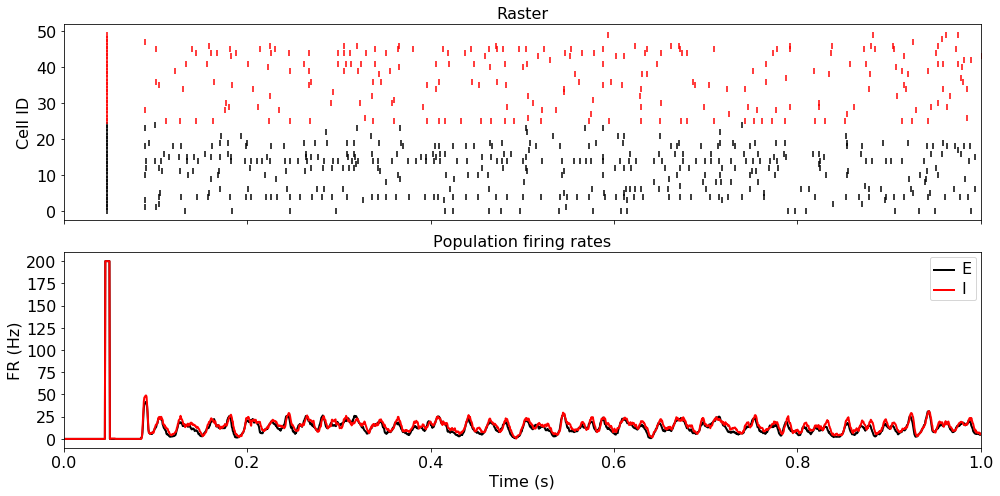

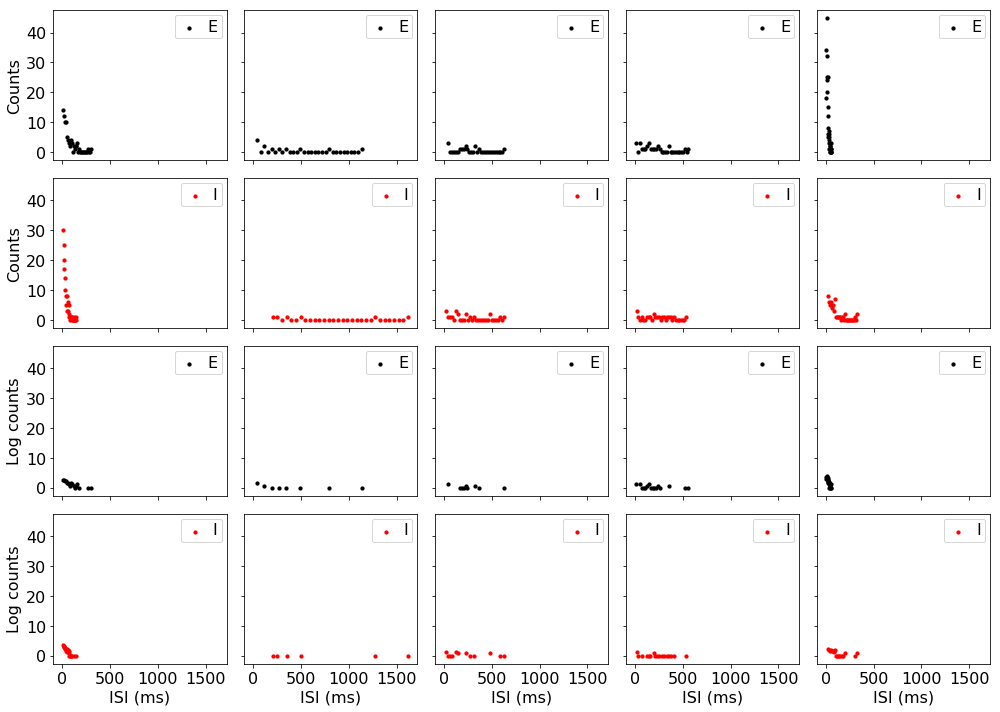

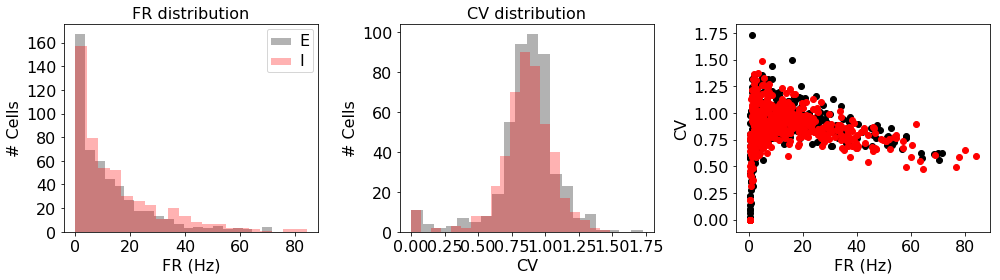

In [8]:
np.random.seed(0)

# set up weight matrix
n_e = 500
n_i = 500
n = n_e + n_i

q = 0.02  # cxn prob
k_e = int(q*n_e)  # num upstream e inputs to each cell
k_i = int(q*n_i)  # num upstream i inputs to each cell
w_ee = 20e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 3  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.1},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.05}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 25  # first 25 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 25)  # first 25 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 25, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, 1)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, n_e:].T]

## plot example ISIs
fig, axs = plt.subplots(4, 5, figsize=(14, 10), tight_layout=True, sharex=True, sharey=True)
for ctr, ax_col in enumerate(axs.T):
    # E
    cts_e, bins_e = np.histogram(1000 * isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    ax_col[0].scatter(bincs_e, cts_e, c='k', lw=2, s=5)
    ax_col[2].scatter(bincs_e, np.log(cts_e), c='k', lw=2, s=5)
    
    ax_col[0].legend(['E'])
    ax_col[2].legend(['E'])
    
    # I
    cts_i, bins_i = np.histogram(1000 * isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    ax_col[1].scatter(bincs_i, cts_i, c='r', lw=2, s=5)
    ax_col[3].scatter(bincs_i, np.log(cts_i), c='r', lw=2, s=5)
    
    ax_col[1].legend(['I'])
    ax_col[3].legend(['I'])

for ax in axs[:2, 0]:
    ax.set_ylabel('Counts')
for ax in axs[2:, 0]:
    ax.set_ylabel('Log counts')
for ax in axs[-1, :]:
    ax.set_xlabel('ISI (ms)')
for ax in axs.flatten():
    set_font_size(ax, 16)

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc CV (from ISI) distributions
cv_e = np.array([stats.variation(isi) for isi in isis_e])  # E

cv_i = np.array([stats.variation(isi) for isi in isis_i])  # I

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].set_ylabel('# Cells')
axs[0].legend(['E', 'I'])

axs[1].hist(cv_e[~np.isnan(cv_e)], bins=20, color='k', alpha=.3)
axs[1].hist(cv_i[~np.isnan(cv_i)], bins=20, color='r', alpha=.3)

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')
axs[1].set_ylabel('# Cells')

axs[2].scatter(fr_e, cv_e, color='k')
axs[2].scatter(fr_i, cv_i, color='r')

axs[2].set_xlabel('FR (Hz)')
axs[2].set_ylabel('CV')

for ax in axs:
    set_font_size(ax, 16)

Sort of asynchronous irregular.

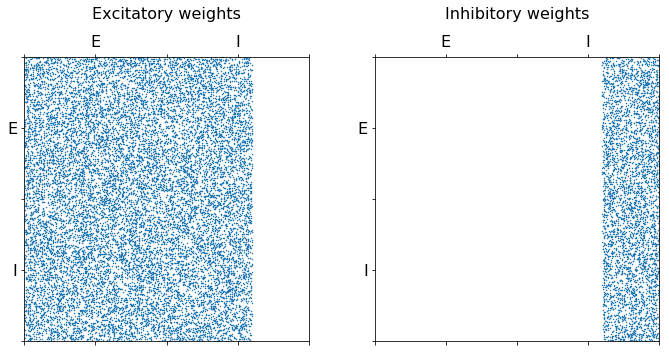

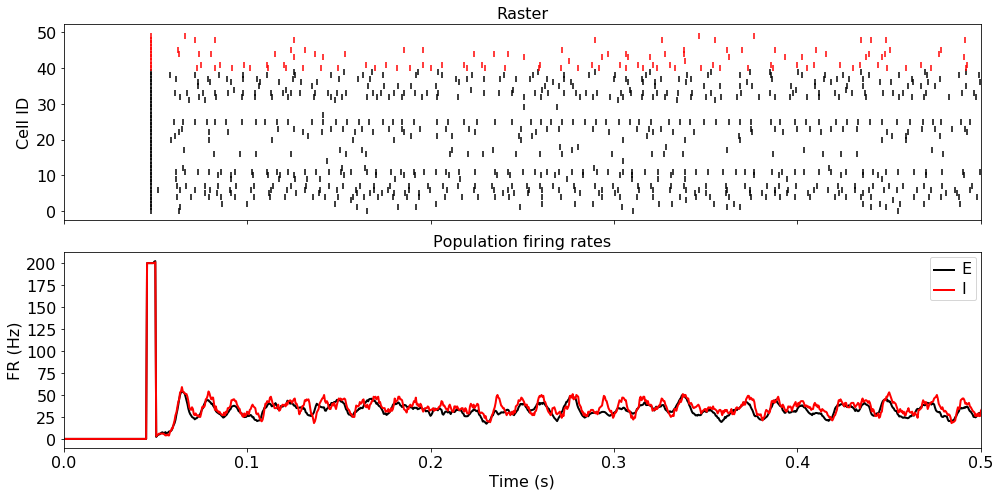

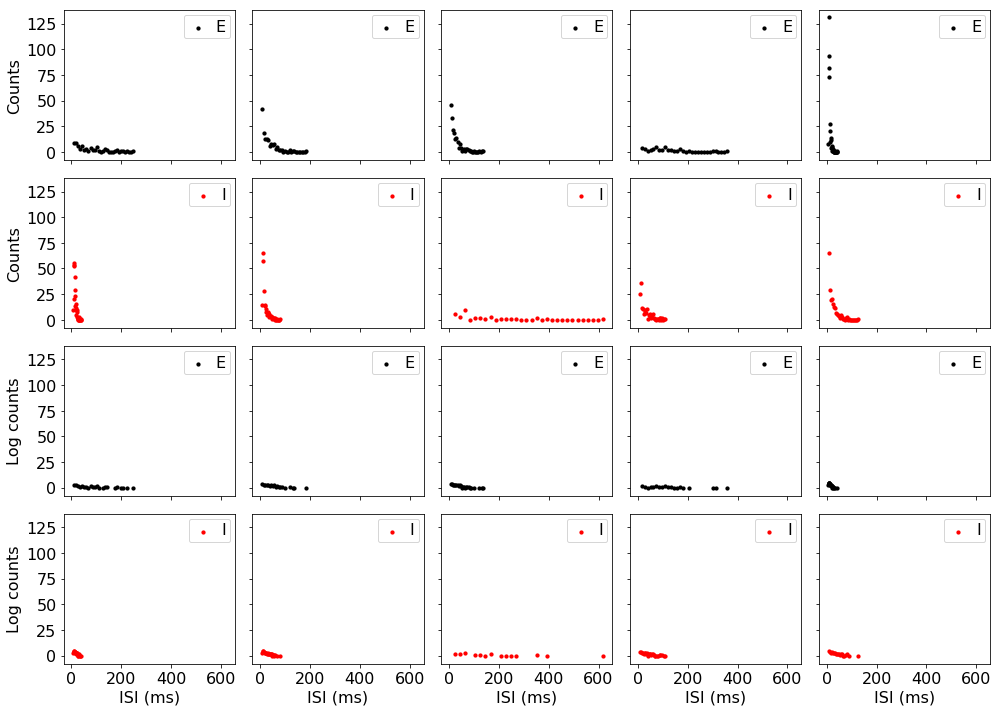

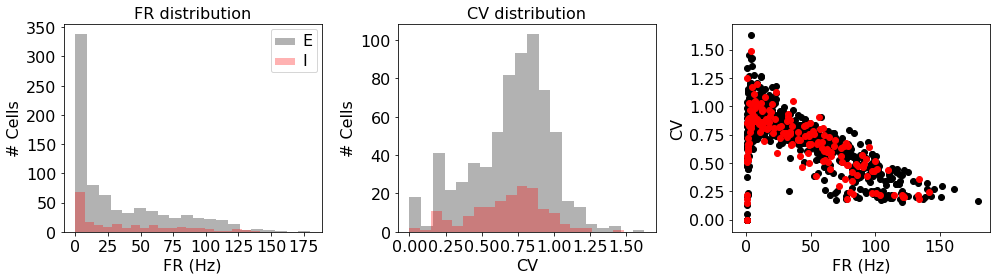

In [9]:
np.random.seed(0)

# set up weight matrix
n_e = 800
n_i = 200
n = n_e + n_i

q = 0.02  # cxn prob
k_e = int(q*n_e)  # num upstream e inputs to each cell
k_i = int(q*n_i)  # num upstream i inputs to each cell
w_ee = 5e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 15  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.05,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.07},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.05}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 40  # first 40 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 10)  # first 10 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 40, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, n_e:].T]

## plot example ISIs
fig, axs = plt.subplots(4, 5, figsize=(14, 10), tight_layout=True, sharex=True, sharey=True)
for ctr, ax_col in enumerate(axs.T):
    # E
    cts_e, bins_e = np.histogram(1000 * isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    ax_col[0].scatter(bincs_e, cts_e, c='k', lw=2, s=5)
    ax_col[2].scatter(bincs_e, np.log(cts_e), c='k', lw=2, s=5)
    
    ax_col[0].legend(['E'])
    ax_col[2].legend(['E'])
    
    # I
    cts_i, bins_i = np.histogram(1000 * isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    ax_col[1].scatter(bincs_i, cts_i, c='r', lw=2, s=5)
    ax_col[3].scatter(bincs_i, np.log(cts_i), c='r', lw=2, s=5)
    
    ax_col[1].legend(['I'])
    ax_col[3].legend(['I'])

for ax in axs[:2, 0]:
    ax.set_ylabel('Counts')
for ax in axs[2:, 0]:
    ax.set_ylabel('Log counts')
for ax in axs[-1, :]:
    ax.set_xlabel('ISI (ms)')
for ax in axs.flatten():
    set_font_size(ax, 16)

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc CV (from ISI) distributions
cv_e = np.array([stats.variation(isi) for isi in isis_e])  # E

cv_i = np.array([stats.variation(isi) for isi in isis_i])  # I

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].set_ylabel('# Cells')
axs[0].legend(['E', 'I'])

axs[1].hist(cv_e[~np.isnan(cv_e)], bins=20, color='k', alpha=.3)
axs[1].hist(cv_i[~np.isnan(cv_i)], bins=20, color='r', alpha=.3)

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')
axs[1].set_ylabel('# Cells')

axs[2].scatter(fr_e, cv_e, color='k')
axs[2].scatter(fr_i, cv_i, color='r')

axs[2].set_xlabel('FR (Hz)')
axs[2].set_ylabel('CV')

for ax in axs:
    set_font_size(ax, 16)

Asynchronous irregular

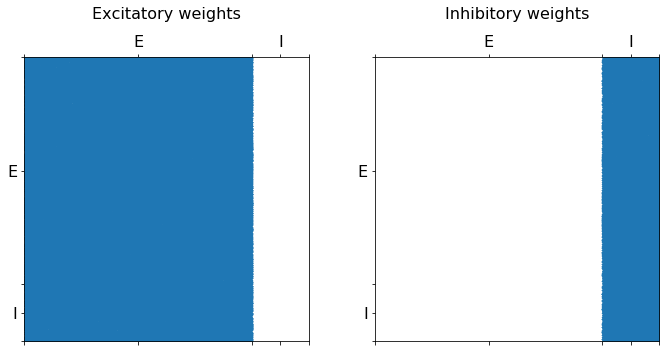

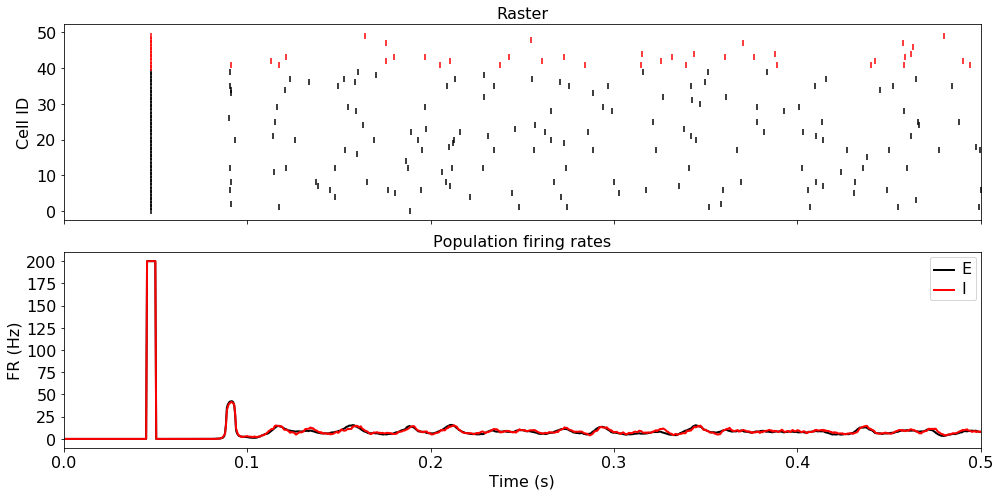

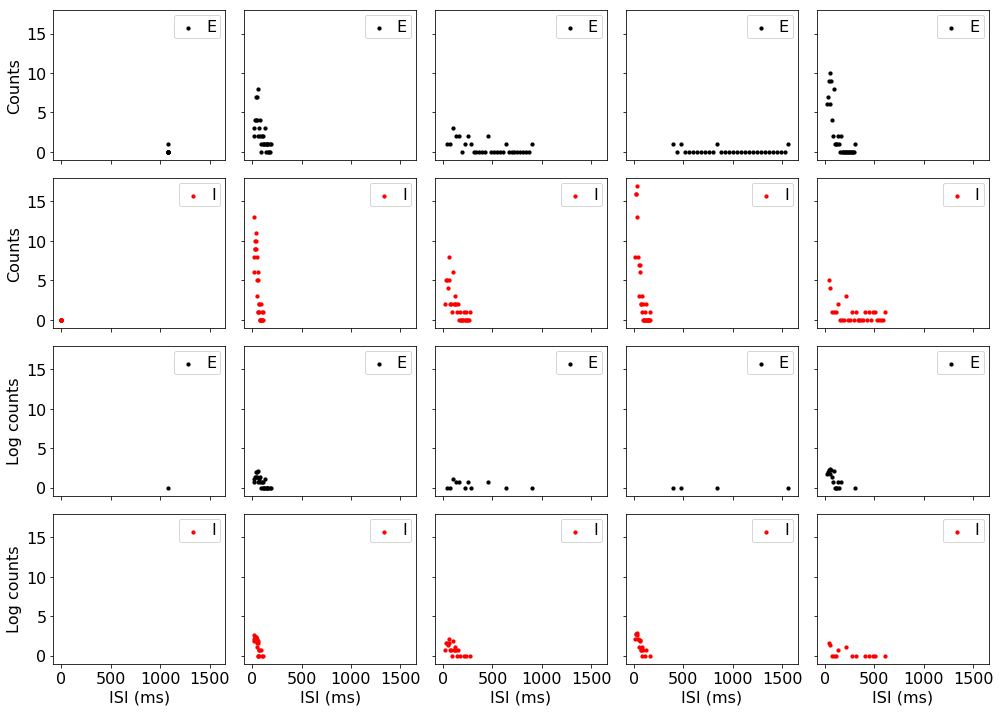

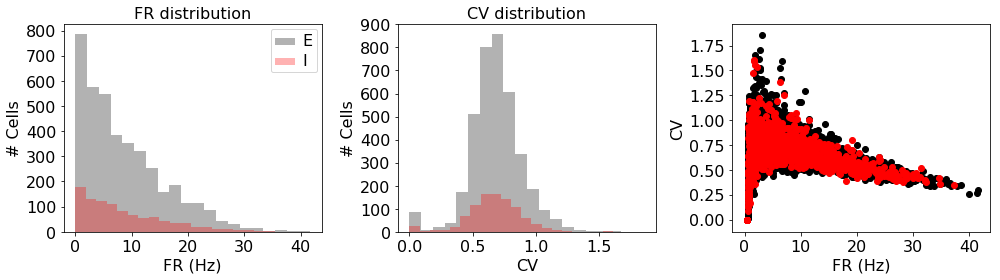

In [10]:
np.random.seed(0)

# set up weight matrix
n_e = 4000
n_i = 1000
n = n_e + n_i

q = 0.02  # cxn prob
k_e = int(q*n_e)  # num upstream e inputs to each cell
k_i = int(q*n_i)  # num upstream i inputs to each cell
w_ee = 1e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 15  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 1999.5, 3999.5, 4499.5, 4999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 1999.5, 3999.5, 4499.5, 4999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkG(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.05,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.07},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.05}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 40  # first 40 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 10)  # first 10 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 40, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, n_e:].T]

## plot example ISIs
fig, axs = plt.subplots(4, 5, figsize=(14, 10), tight_layout=True, sharex=True, sharey=True)
for ctr, ax_col in enumerate(axs.T):
    # E
    cts_e, bins_e = np.histogram(1000 * isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    ax_col[0].scatter(bincs_e, cts_e, c='k', lw=2, s=5)
    ax_col[2].scatter(bincs_e, np.log(cts_e), c='k', lw=2, s=5)
    
    ax_col[0].legend(['E'])
    ax_col[2].legend(['E'])
    
    # I
    cts_i, bins_i = np.histogram(1000 * isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    ax_col[1].scatter(bincs_i, cts_i, c='r', lw=2, s=5)
    ax_col[3].scatter(bincs_i, np.log(cts_i), c='r', lw=2, s=5)
    
    ax_col[1].legend(['I'])
    ax_col[3].legend(['I'])

for ax in axs[:2, 0]:
    ax.set_ylabel('Counts')
for ax in axs[2:, 0]:
    ax.set_ylabel('Log counts')
for ax in axs[-1, :]:
    ax.set_xlabel('ISI (ms)')
for ax in axs.flatten():
    set_font_size(ax, 16)

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc CV (from ISI) distributions
cv_e = np.array([stats.variation(isi) for isi in isis_e])  # E

cv_i = np.array([stats.variation(isi) for isi in isis_i])  # I

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].set_ylabel('# Cells')
axs[0].legend(['E', 'I'])

axs[1].hist(cv_e[~np.isnan(cv_e)], bins=20, color='k', alpha=.3)
axs[1].hist(cv_i[~np.isnan(cv_i)], bins=20, color='r', alpha=.3)

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')
axs[1].set_ylabel('# Cells')

axs[2].scatter(fr_e, cv_e, color='k')
axs[2].scatter(fr_i, cv_i, color='r')

axs[2].set_xlabel('FR (Hz)')
axs[2].set_ylabel('CV')

for ax in axs:
    set_font_size(ax, 16)

# Current-based LIF network

Non-plastic spiking network with current-based synapses and balanced state demo (in asynchronous irregular regime).

In [11]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.ndimage import uniform_filter1d as mv_avg
from scipy import stats

from aux import Generic
from disp import set_font_size, set_color
from ntwk import LIFNtwkI, join_w

cc = np.concatenate

## Basic tests

Single-cell response to step current:

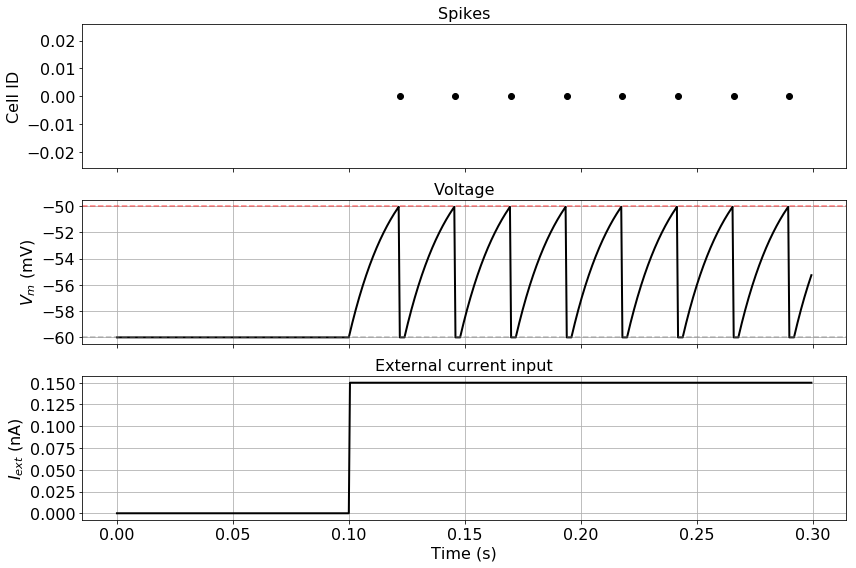

In [12]:
# build 1-cell ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=np.zeros((1, 1)),
    w_u=None,
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
i_ext[t > 0.1] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

axs[2].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[2].set_title('External current input')
axs[2].set_ylabel('$I_{ext}$ (nA)')
axs[2].set_xlabel('Time (s)')

for ax in axs:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell EPSPs:

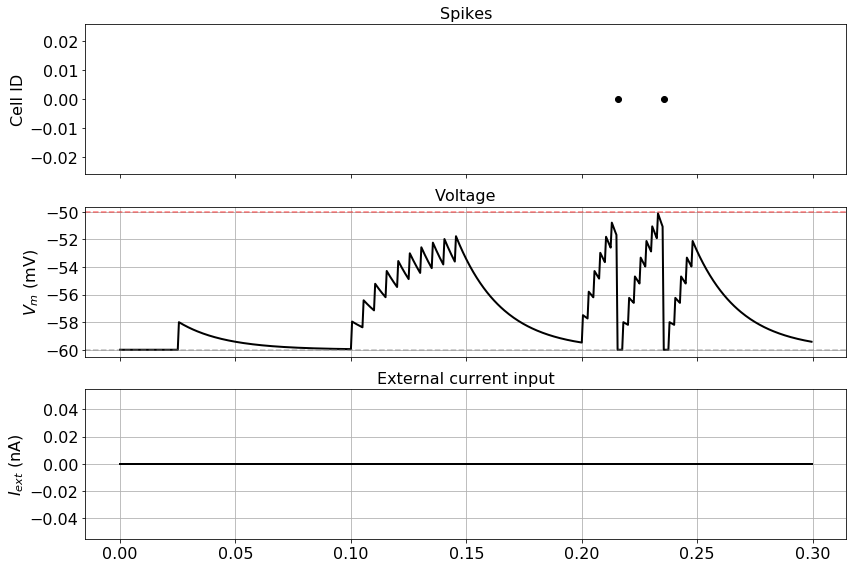

In [13]:
# build 1-cell ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=np.zeros((1, 1)),
    w_u=.8e-9*np.ones((1, 1)),
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

axs[2].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[2].set_title('External current input')
axs[2].set_ylabel('$I_{ext}$ (nA)')

for ax in axs:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell IPSPs:

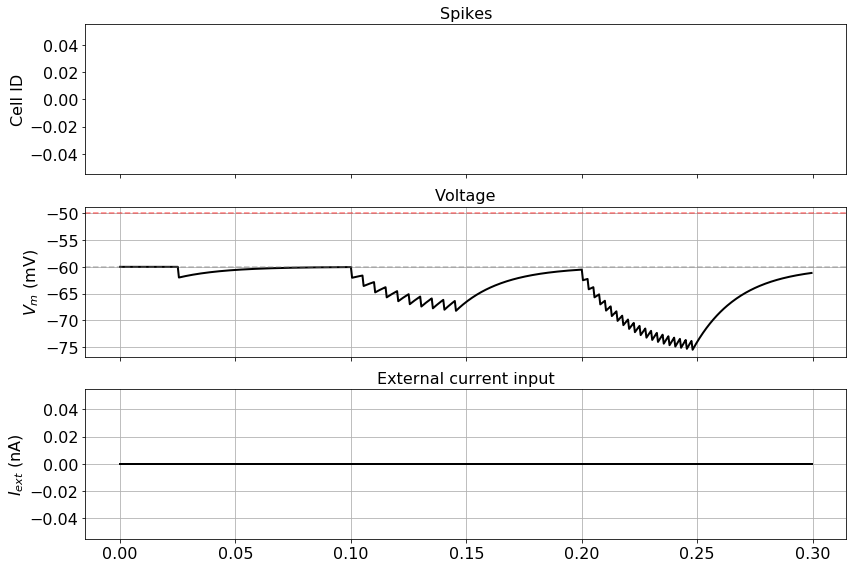

In [14]:
# build 1-cell ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=np.zeros((1, 1)),
    w_u=-.8e-9*np.ones((1, 1)),
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

axs[2].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[2].set_title('External current input')
axs[2].set_ylabel('$I_{ext}$ (nA)')

for ax in axs:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives EPSPs from cell A.

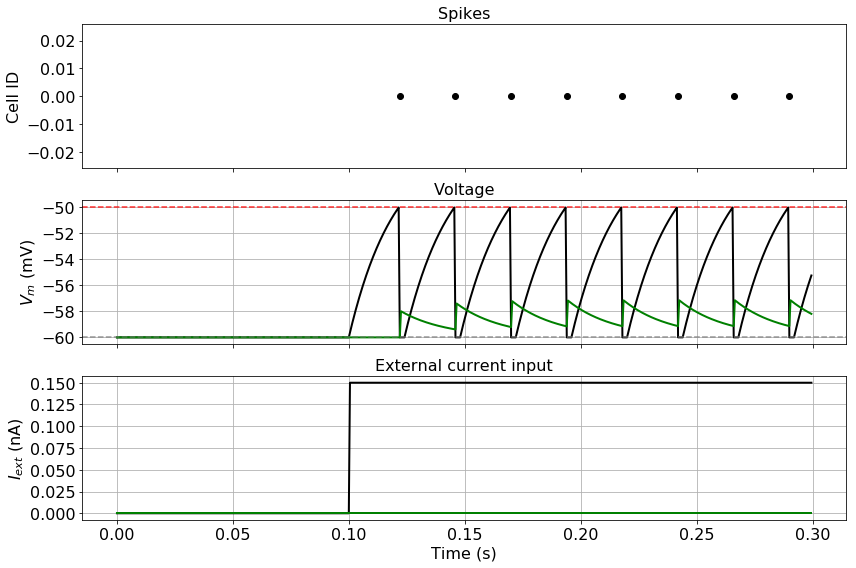

In [15]:
# build 2-cell ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=.8e-9*np.array([[0, 0], [1, 0]]),
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[2].set_title('External current input')
axs[2].set_ylabel('$I_{ext}$ (nA)')
axs[2].set_xlabel('Time (s)')

for ax in axs:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives IPSPs from cell A.

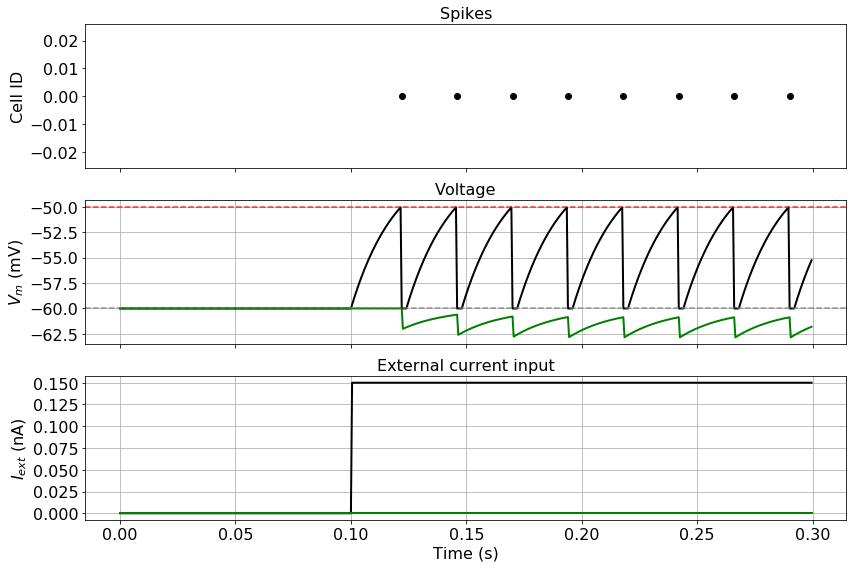

In [16]:
# build 2-cell ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=-.8e-9*np.array([[0, 0], [1, 0]]),
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[2].set_title('External current input')
axs[2].set_ylabel('$I_{ext}$ (nA)')
axs[2].set_xlabel('Time (s)')

for ax in axs:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

## Random balanced network demos

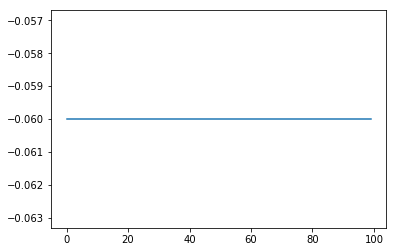

In [17]:
plt.plot(rslt.vs[:100, 0])

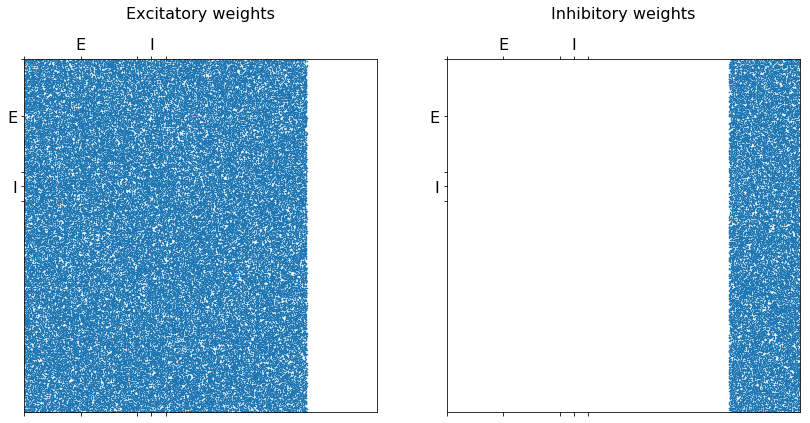

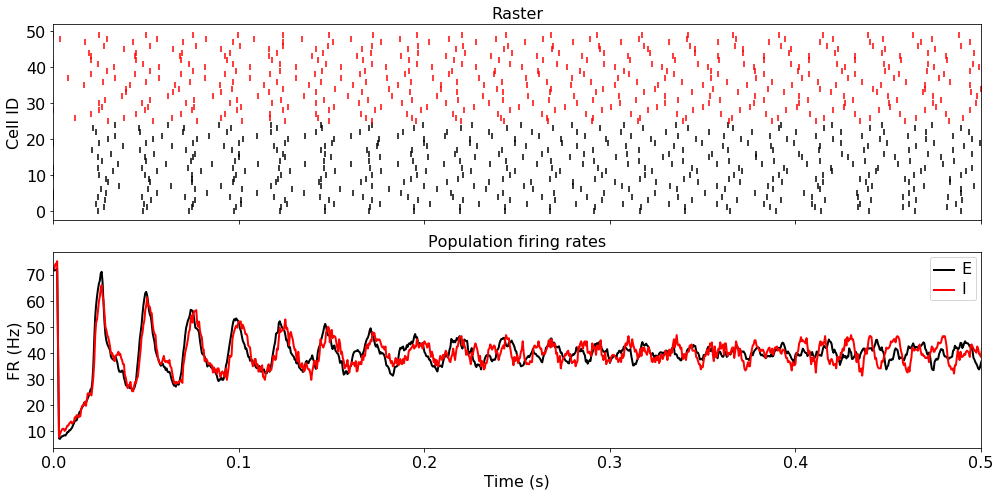

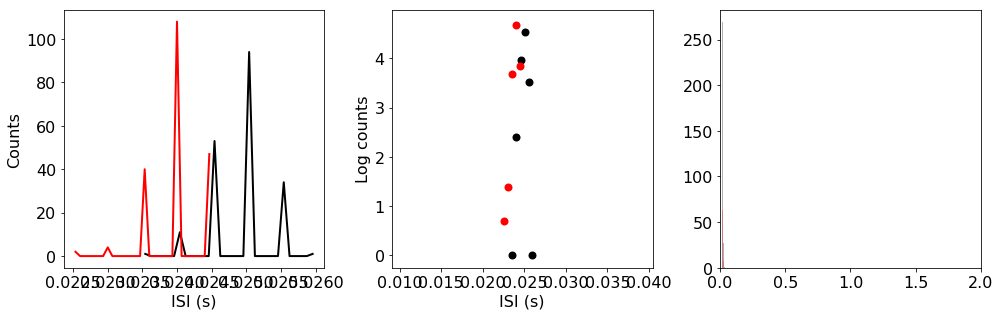

In [18]:
np.random.seed(0)

# set up weight matrix
n_e = 2000
n_i = 500
n = n_e + n_i

q = 0.02  # cxn prob
w_ee = .01e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 6  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = -g*w_ee  # I->E cxn weight
w_ii = -g*w_ie  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'W': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)['W']

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    w_r_e = copy(w_r)
    w_r_e[w_r < 0] = 0
    axs[0].spy(w_r_e, markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    
    w_r_i = copy(w_r)
    w_r_i[w_r > 0] = 0
    axs[1].spy(w_r_i, markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwkI(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    w_r=w_r,
    w_u=None,
    sparse=True)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: np.random.normal(-0.06, .01, n)}, spk={})
i_ext = .15e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 25  # first 25 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 25)  # first 25 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 25, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, n_e:].T]
## calc ISI coef of variation
cv_e = np.array([stats.variation(isi) for isi in isis_e])
cv_i = np.array([stats.variation(isi) for isi in isis_i])
cv_e = cv_e[~np.isnan(cv_e)]
cv_i = cv_i[~np.isnan(cv_i)]

## make plots
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5), tight_layout=True)

## example ISIs
for ctr in range(1):
    ### excitatory
    cts_e, bins_e = np.histogram(isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    axs[0].plot(bincs_e, cts_e, c='k', lw=2)
    axs[1].scatter(bincs_e, np.log(cts_e), c='k', lw=2)
    
    ### inhibitory
    cts_i, bins_i = np.histogram(isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    axs[0].plot(bincs_i, cts_i, c='r', lw=2)
    axs[1].scatter(bincs_i, np.log(cts_i), c='r', lw=2)
    
axs[0].set_xlabel('ISI (s)')
axs[0].set_ylabel('Counts')

axs[1].set_xlabel('ISI (s)')
axs[1].set_ylabel('Log counts')

## CV distribution
bins = np.histogram(cc([cv_e, cv_i]), bins=30)[1]
axs[2].hist(cv_e, bins, color='k', alpha=0.3)
axs[2].hist(cv_i, bins, color='r', alpha=0.3)
axs[2].set_xticks([0, .5, 1, 1.5, 2])

for ax in axs:
    set_font_size(ax, 16)